In [1]:
# Set seed for reproducibility
SEED = 42
LOCAL = True

# Import necessary libraries
import os, subprocess, shlex

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)


def mac_physical_cores():
    try:
        out = subprocess.check_output(shlex.split("sysctl -n hw.physicalcpu")).decode().strip()
        return int(out)
    except Exception:
        return max(1, (os.cpu_count() or 2) // 2)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
# from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

if (LOCAL):
    
    PHYS = mac_physical_cores()

    # Leave one core free for the OS (helps thermals on Airs)
    OMP = max(1, PHYS - 1)

    # --- OpenMP / BLAS knobs (set BEFORE importing torch) ---
    os.environ.setdefault("OMP_NUM_THREADS", str(OMP))            # OpenMP (oneDNN, some kernels)
    os.environ.setdefault("VECLIB_MAXIMUM_THREADS", str(OMP))     # Apple Accelerate / vecLib
    os.environ.setdefault("OPENBLAS_NUM_THREADS", str(OMP))       # If any dep uses OpenBLAS
    os.environ.setdefault("MKL_NUM_THREADS", str(OMP))            # Rare on macOS, harmless if unused
    os.environ.setdefault("MKL_DYNAMIC", "FALSE")                 # Avoid oversubscription if MKL present

    device = torch.device("cpu")  # Intel Mac: CPU only

    torch.manual_seed(SEED)
    torch.set_num_threads(OMP)        # intra-op threads
    torch.set_num_interop_threads(1)  # parallel ops; start low on laptops

    print(f"device={device}, physical_cores={PHYS}, "
        f"OMP_NUM_THREADS={OMP}, "
        f"torch_threads={torch.get_num_threads()}, "
        f"interop={torch.get_num_interop_threads()}")





print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

device=cpu, physical_cores=4, OMP_NUM_THREADS=3, torch_threads=3, interop=1
PyTorch version: 2.9.0+cu128
Device: cpu


sysctl: cannot stat /proc/sys/hw/physicalcpu: No such file or directory


In [2]:
X_train = pd.read_csv('pirate_pain_train.csv')
y_train = pd.read_csv('pirate_pain_train_labels.csv')

X_test = pd.read_csv('pirate_pain_test.csv')

# Create mapping dictionary for pain levels
pain_mapping = {
    'no_pain': 0,
    'low_pain': 1,
    'high_pain': 2
}

# First map the labels in y_train
y_train['label_encoded'] = y_train['label'].map(pain_mapping)

# Then merge with X_train based on sample_index
X_train = X_train.merge(
    y_train[['sample_index', 'label_encoded']], 
    on='sample_index', 
    how='left'
)

# Rename the column
X_train.rename(columns={'label_encoded': 'label'}, inplace=True)

# Verify the mapping worked correctly
print("\nFirst few rows of X_train with encoded labels:")
print(X_train[['sample_index', 'label']].head(50))

print("\nLabel value counts:")
print(X_train['label'].value_counts())

print("\nCheck for NaN labels:")
print(f"NaN count: {X_train['label'].isna().sum()}")

labels = ['no_pain', 'low_pain', 'high_pain']


First few rows of X_train with encoded labels:
    sample_index  label
0              0      0
1              0      0
2              0      0
3              0      0
4              0      0
5              0      0
6              0      0
7              0      0
8              0      0
9              0      0
10             0      0
11             0      0
12             0      0
13             0      0
14             0      0
15             0      0
16             0      0
17             0      0
18             0      0
19             0      0
20             0      0
21             0      0
22             0      0
23             0      0
24             0      0
25             0      0
26             0      0
27             0      0
28             0      0
29             0      0
30             0      0
31             0      0
32             0      0
33             0      0
34             0      0
35             0      0
36             0      0
37             0      0
38             0

In [3]:
# Drop joint_30 column (contains only NaN values)
print("Dropping joint_30 column (all NaN values)...")
for df in [X_train, X_test]:
    if 'joint_30' in df.columns:
        df.drop('joint_30', axis=1, inplace=True)
        print(f"Dropped joint_30 from {df.shape}")

print("\nColumns after dropping joint_30:")
print(f"X_train columns: {X_train.shape[1]}")
print(f"X_test columns: {X_test.shape[1]}")

Dropping joint_30 column (all NaN values)...
Dropped joint_30 from (105760, 40)
Dropped joint_30 from (211840, 39)

Columns after dropping joint_30:
X_train columns: 40
X_test columns: 39


In [4]:
print("\n--- Data successfully loaded ---")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")

print("\n--- Initial Feature Count Breakdown ---")
all_features = X_train.columns.drop(['sample_index', 'time'])
joint_features = [col for col in all_features if col.startswith('joint_')]
static_features = [col for col in all_features if col in ['n_legs', 'n_hands', 'n_eyes']]

print(f"Total Features (excluding IDs): {len(all_features)}")
print(f"Core Time-Series (Joints): {len(joint_features)} columns")
print(f"Static Subject Characteristics: {len(static_features)} columns")
print(f"Pain Survey Features: {len(all_features) - len(joint_features) - len(static_features)} columns")





--- Data successfully loaded ---
X_train shape: (105760, 40)
y_train shape: (661, 3)
X_test shape: (211840, 39)

--- Initial Feature Count Breakdown ---
Total Features (excluding IDs): 38
Core Time-Series (Joints): 30 columns
Static Subject Characteristics: 3 columns
Pain Survey Features: 5 columns


In [5]:
# First: Convert categorical variables to binary (two -> 1, others -> 0)
binary_cols = ['n_hands', 'n_eyes', 'n_legs']
for col in binary_cols:
    for df_ in [X_train, X_test]:
        df_[col] = df_[col].map(lambda x: 1 if str(x).lower().strip() == 'two' else 0)



In [6]:
print("\n--- Data structure ---")
print("\nX_train Info:")
X_train.info(verbose=True)
print(f"\nMissing values in X_train: {X_train.isnull().sum().sum()}")
print("\ny_train Info:")
y_train.info(verbose=True)
print(f"\nMissing values in y_train: {y_train.isnull().sum().sum()}")


--- Data structure ---

X_train Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 40 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  int64  
 3   pain_survey_2  105760 non-null  int64  
 4   pain_survey_3  105760 non-null  int64  
 5   pain_survey_4  105760 non-null  int64  
 6   n_legs         105760 non-null  int64  
 7   n_hands        105760 non-null  int64  
 8   n_eyes         105760 non-null  int64  
 9   joint_00       105760 non-null  float64
 10  joint_01       105760 non-null  float64
 11  joint_02       105760 non-null  float64
 12  joint_03       105760 non-null  float64
 13  joint_04       105760 non-null  float64
 14  joint_05       105760 non-null  float64
 15  joint_06       105760 non-null  float64
 16  joint_07       105760 non-null  flo

In [7]:
X_train.describe()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,label
count,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,...,1.057600e+05,1.057600e+05,1.057600e+05,1.057600e+05,1.057600e+05,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000
mean,330.000000,79.500000,1.633746,1.654851,1.653640,1.663134,0.990923,0.990923,0.990923,0.943095,...,3.972126e-05,4.176794e-05,3.561780e-05,3.138109e-05,1.024604e-04,0.041905,0.058244,0.049886,0.062273,0.311649
std,190.814948,46.187338,0.682423,0.669639,0.666649,0.661994,0.094841,0.094841,0.094841,0.202051,...,4.974496e-03,5.472244e-03,1.235450e-03,4.062914e-04,3.206128e-03,0.060293,0.079819,0.060773,0.072597,0.619651
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,1.510494e-07,0.000000e+00,1.063144e-08,0.000000e+00,0.000203,0.000000,0.000000,0.000000,0.000000
25%,165.000000,39.750000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,0.828277,...,6.545878e-08,3.321650e-07,3.275038e-07,2.841805e-07,7.161332e-07,0.009885,0.012652,0.016290,0.019638,0.000000
50%,330.000000,79.500000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.005126,...,8.302747e-07,1.095971e-06,1.024209e-06,8.746147e-07,3.126723e-06,0.021898,0.031739,0.031843,0.039041,0.000000
75%,495.000000,119.250000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.081039,...,2.800090e-06,3.079465e-06,3.021830e-06,2.507548e-06,9.946107e-06,0.048579,0.071051,0.058741,0.079518,0.000000
max,660.000000,159.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.407968,...,1.442198e+00,1.305001e+00,2.742411e-01,3.643074e-02,9.473540e-01,1.223617,1.187419,1.412037,1.370765,2.000000


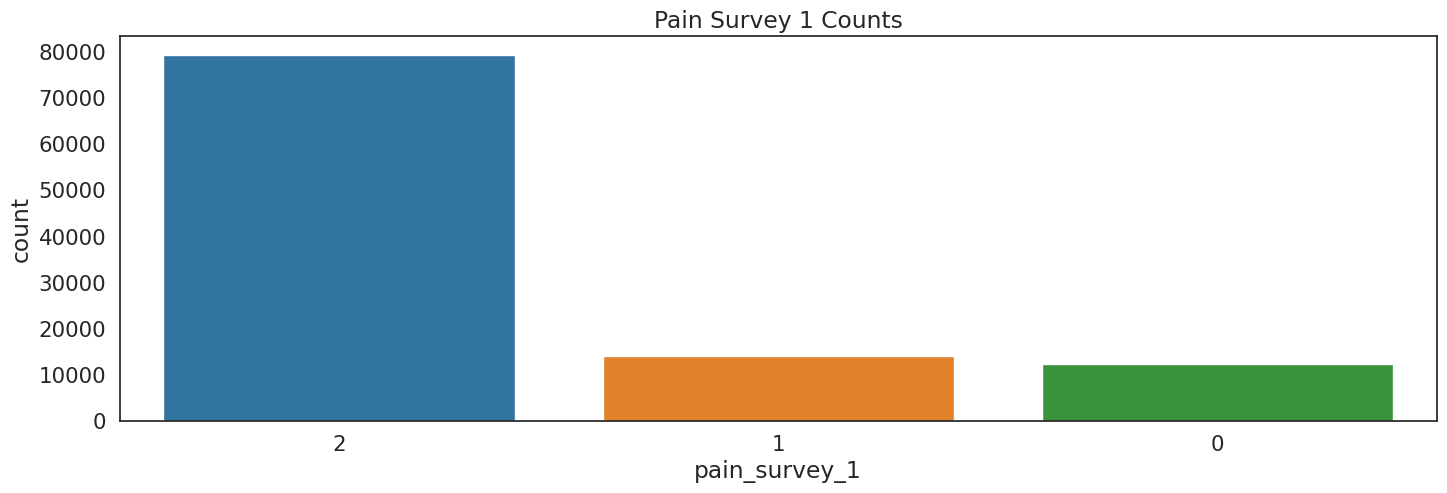

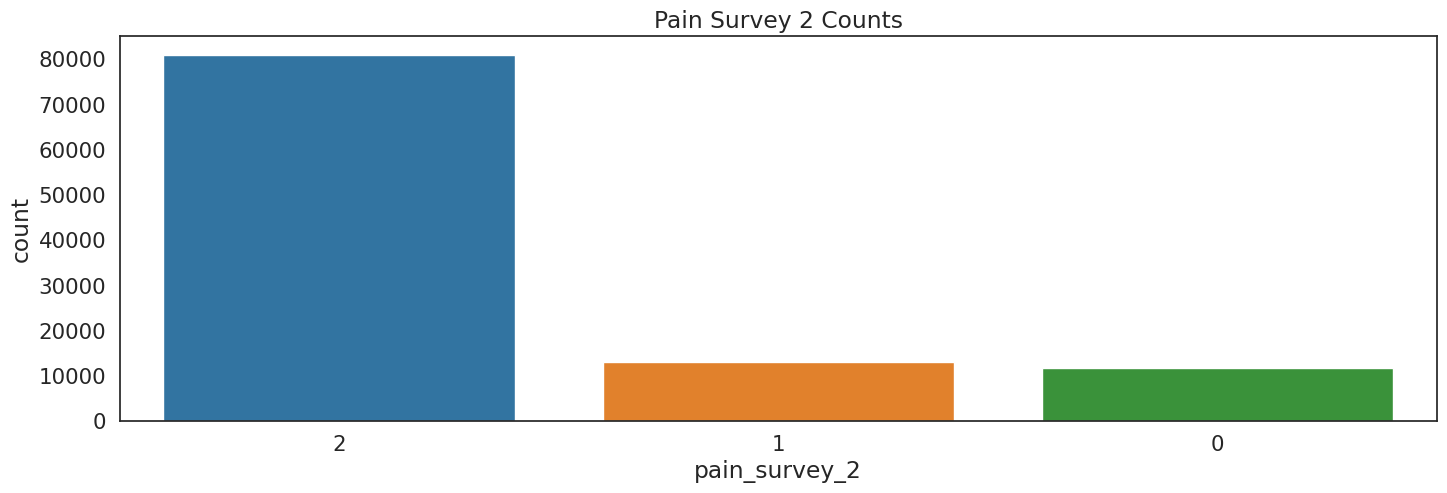

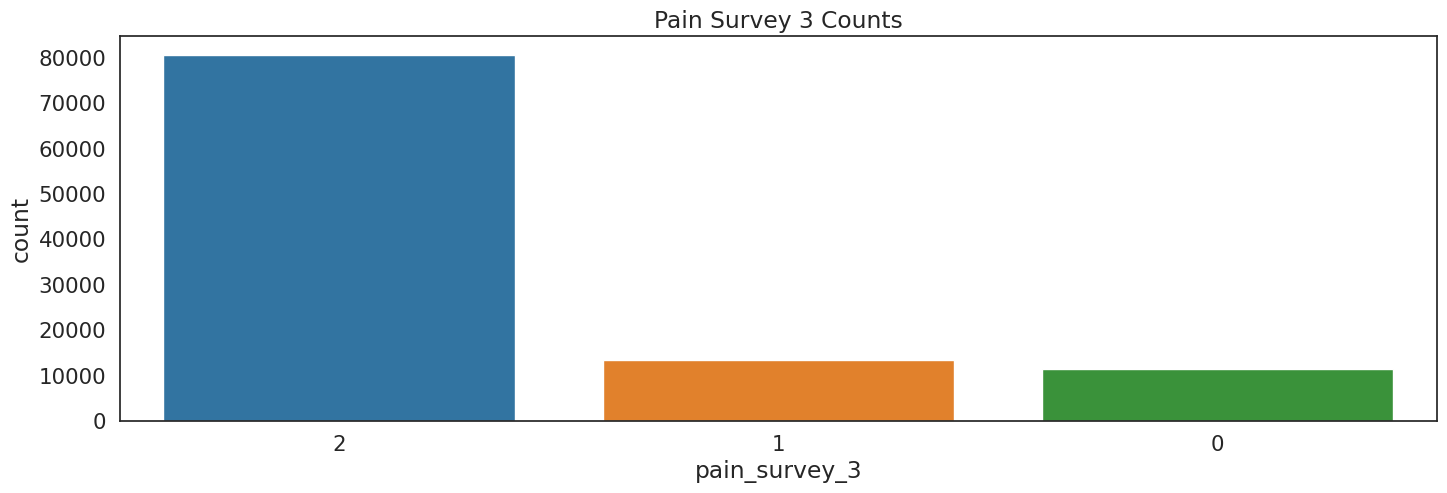

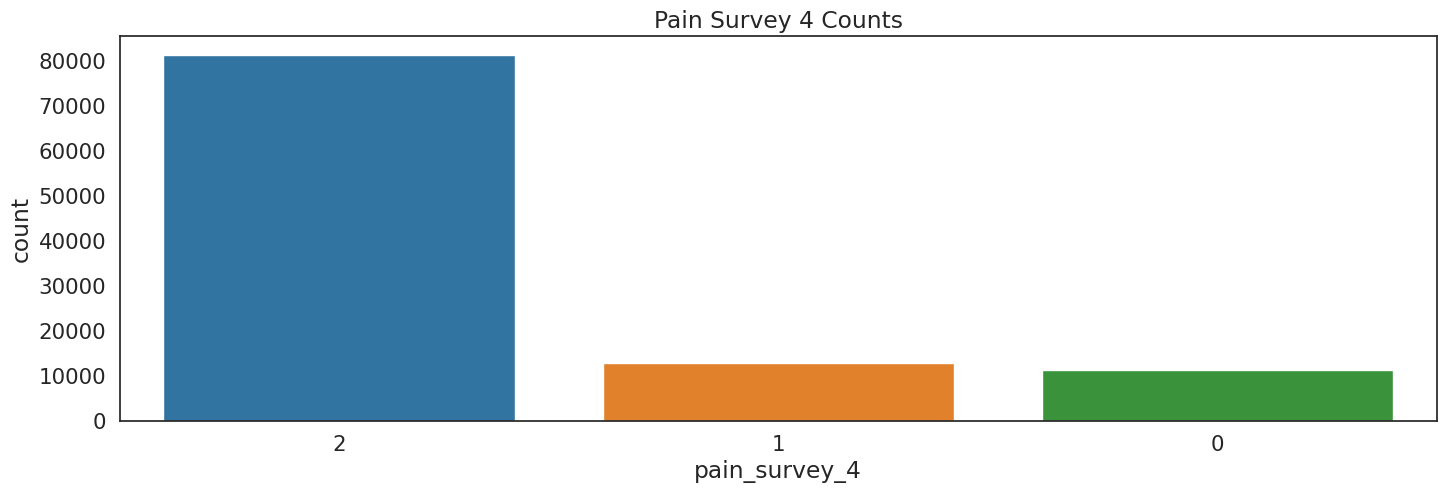

In [8]:
# Visualise the count of timestamps for each activity
plt.figure(figsize=(17, 5))
sns.countplot(
    x='pain_survey_1',
    data=X_train,
    order=X_train['pain_survey_1'].value_counts().index,
    palette='tab10'
)

# Set the title of the plot
plt.title('Pain Survey 1 Counts')

# Display the plot
plt.show()

plt.figure(figsize=(17, 5))
sns.countplot(
    x='pain_survey_2',
    data=X_train,
    order=X_train['pain_survey_2'].value_counts().index,
    palette='tab10'
)

# Set the title of the plot
plt.title('Pain Survey 2 Counts')

# Display the plot
plt.show()

plt.figure(figsize=(17, 5))
sns.countplot(
    x='pain_survey_3',
    data=X_train,
    order=X_train['pain_survey_3'].value_counts().index,
    palette='tab10'
)

# Set the title of the plot
plt.title('Pain Survey 3 Counts')

# Display the plot
plt.show()


plt.figure(figsize=(17, 5))
sns.countplot(
    x='pain_survey_4',
    data=X_train,
    order=X_train['pain_survey_4'].value_counts().index,
    palette='tab10'
)

# Set the title of the plot
plt.title('Pain Survey 4 Counts')

# Display the plot
plt.show()

In [9]:
# Get unique user IDs and shuffle them
unique_users = X_train['sample_index'].unique()
random.seed(SEED) # Ensure reproducibility of shuffling
random.shuffle(unique_users)

# Define the number of users for validation and test sets
N_VAL_USERS = 50 # You can change this number

# Calculate the number of users for the training set
n_train_users = len(unique_users) - N_VAL_USERS

# Split the shuffled user IDs into training, validation, and test sets
train_users = unique_users[:n_train_users]
val_users = unique_users[n_train_users:n_train_users + N_VAL_USERS]

# Split the dataset into training, validation, and test sets based on user IDs
df_train = X_train[X_train['sample_index'].isin(train_users)]
df_val = X_train[X_train['sample_index'].isin(val_users)]
df_test = X_test
# Print the shapes of the training, validation, and test sets
print(f'Training set shape: {df_train.shape}')
print(f'Validation set shape: {df_val.shape}')
print(f'Test set shape: {df_test.shape}')


Training set shape: (97760, 40)
Validation set shape: (8000, 40)
Test set shape: (211840, 39)


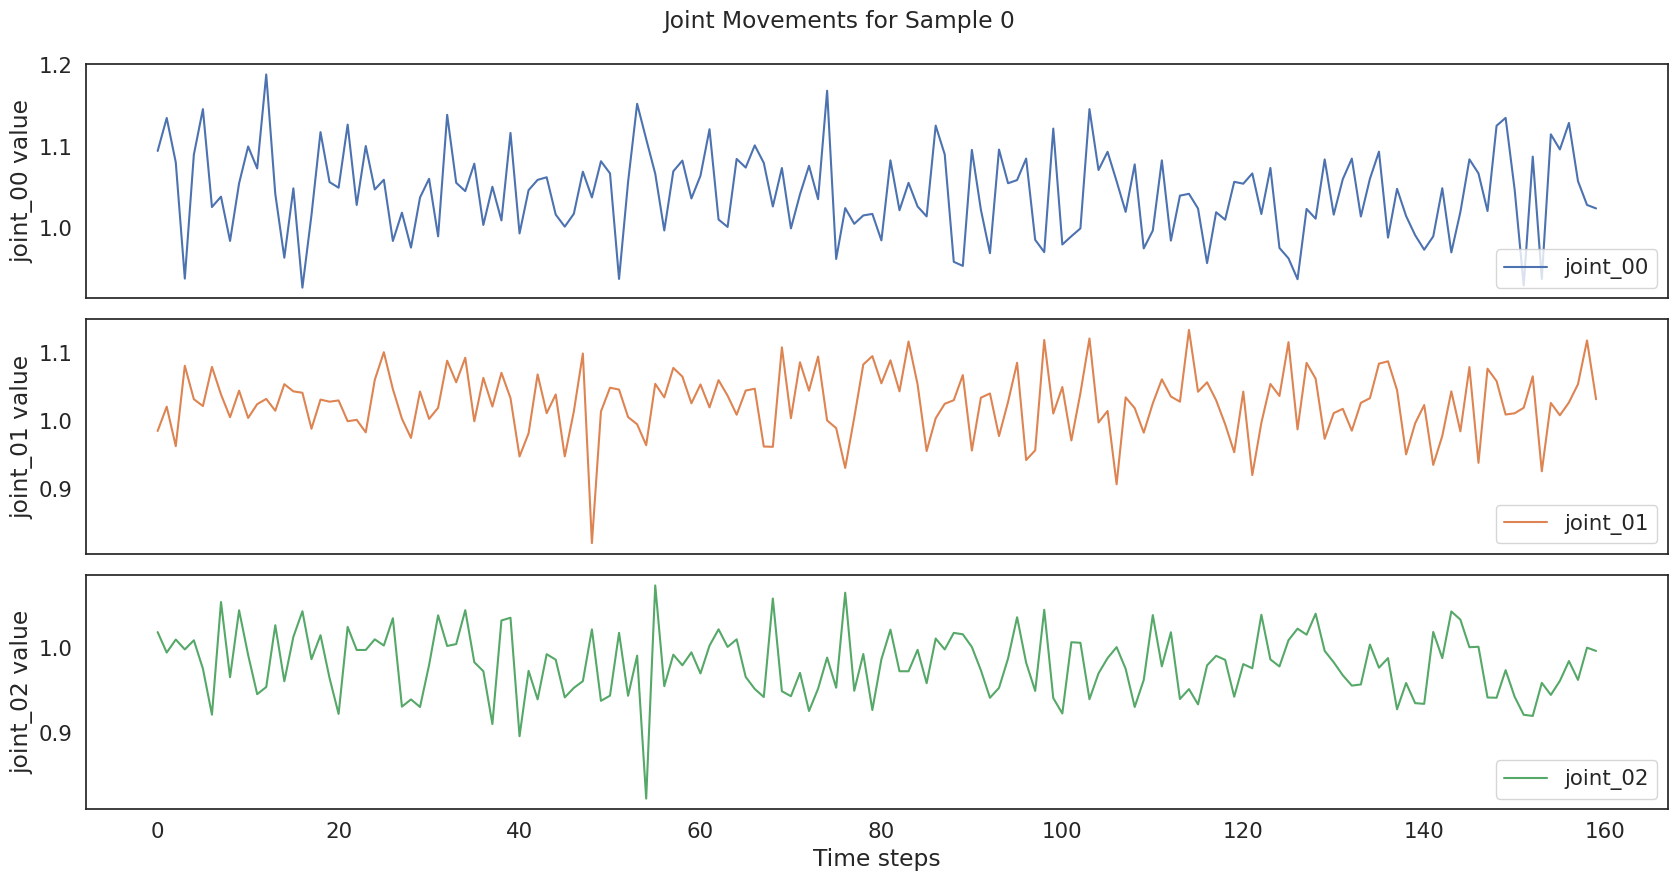

In [10]:
def inspect_activity(sample_index, df, n_samples=500):
    """
    Plot joint movements for a specific sample
    
    Args:
        sample_index: ID of the sample to inspect
        df: DataFrame with the data
        n_samples: Number of timepoints to plot
    """
    # Filter data for the specific sample
    data = df[df['sample_index'] == sample_index][:n_samples]
    
    # Get first three joints (without duplicates)
    joint_data = [f'joint_0{i}' for i in range(3)]  # Plot first 3 joints
    
    # Plot
    axis = data[joint_data].plot(subplots=True, figsize=(17, 9), 
                                title=f'Joint Movements for Sample {sample_index}')
    
    # Customize subplots
    for ax, joint in zip(axis, joint_data):
        ax.legend(loc='lower right')
        ax.set_xlabel('Time steps')
        ax.set_ylabel(f'{joint} value')
    
    plt.tight_layout()
    plt.show()

# Example usage:
sample_to_inspect = df_train['sample_index'].iloc[0]  # Get first sample ID
inspect_activity(sample_to_inspect, df_train)

In [11]:
# Define the columns to be normalised
pain_survey_columns = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 'n_legs', 'n_hands', 'n_eyes'] 
###---------_ATTENTION-------- removed joint_30


#########-------------------------###########
joint_columns = [f'joint_{i:02d}' for i in range(30)]  # Creates joint_00 through joint_29
scale_columns = pain_survey_columns + joint_columns


# Calculate the minimum and maximum values from the training data only
mins = df_train[scale_columns].min()
maxs = df_train[scale_columns].max()

# Add small epsilon to avoid division by zero
denom = (maxs - mins) + 1e-8

print(denom[scale_columns])

# Apply normalisation to the specified columns in all datasets
for column in scale_columns:
    # Normalise the training set
    df_train[column] = (df_train[column] - mins[column]) / denom[column]
    if (df_train[column].isna().any()):
        raise ValueError("Found NaN values in training set after normalization.")
    # Normalise the validation set 
    df_val[column] = (df_val[column] - mins[column]) / denom[column]
    if (df_val[column].isna().any()):
        raise ValueError("Found NaN values in validation set after normalization.")

    # Normalise the test set
    df_test[column] = (df_test[column] - mins[column]) / denom[column]
    if (df_test[column].isna().any()):
        raise ValueError("Found NaN values in test set after normalization.")

# Verify normalization
print("Training set range:")
print(df_train[scale_columns].agg(['min', 'max']).T)

pain_survey_1    2.000000
pain_survey_2    2.000000
pain_survey_3    2.000000
pain_survey_4    2.000000
n_legs           1.000000
n_hands          1.000000
n_eyes           1.000000
joint_00         1.407968
joint_01         1.334613
joint_02         1.305031
joint_03         1.249325
joint_04         1.359204
joint_05         1.387731
joint_06         1.410532
joint_07         1.361969
joint_08         1.235192
joint_09         1.383433
joint_10         1.523577
joint_11         1.391924
joint_12         1.289618
joint_13         0.073052
joint_14         0.264232
joint_15         0.087753
joint_16         0.073377
joint_17         0.420947
joint_18         0.728382
joint_19         0.616061
joint_20         1.096014
joint_21         1.442198
joint_22         1.305001
joint_23         0.274241
joint_24         0.036431
joint_25         0.947354
joint_26         1.223414
joint_27         1.187419
joint_28         1.412037
joint_29         1.370765
dtype: float64
Training set range:
   

Statistiche di normalizzazione (train):
               min  max      mean       std
pain_survey_1  0.0  1.0  0.815932  0.341779
pain_survey_2  0.0  1.0  0.827695  0.334410
pain_survey_3  0.0  1.0  0.826079  0.333710
pain_survey_4  0.0  1.0  0.831639  0.330882
n_legs         0.0  1.0  0.990180  0.098608
n_hands        0.0  1.0  0.990180  0.098608
n_eyes         0.0  1.0  0.990180  0.098608
joint_00       0.0  1.0  0.668287  0.145477
joint_01       0.0  1.0  0.686756  0.150295
joint_02       0.0  1.0  0.595413  0.226342
joint_03       0.0  1.0  0.610820  0.241365
joint_04       0.0  1.0  0.521853  0.307640
joint_05       0.0  1.0  0.514326  0.296197
joint_06       0.0  1.0  0.620022  0.171106
joint_07       0.0  1.0  0.615760  0.174713
joint_08       0.0  1.0  0.586422  0.146598
joint_09       0.0  1.0  0.652217  0.131502
joint_10       0.0  1.0  0.386772  0.168365
joint_11       0.0  1.0  0.446586  0.186916
joint_12       0.0  1.0  0.728325  0.086702
joint_13       0.0  1.0  0.001097  0

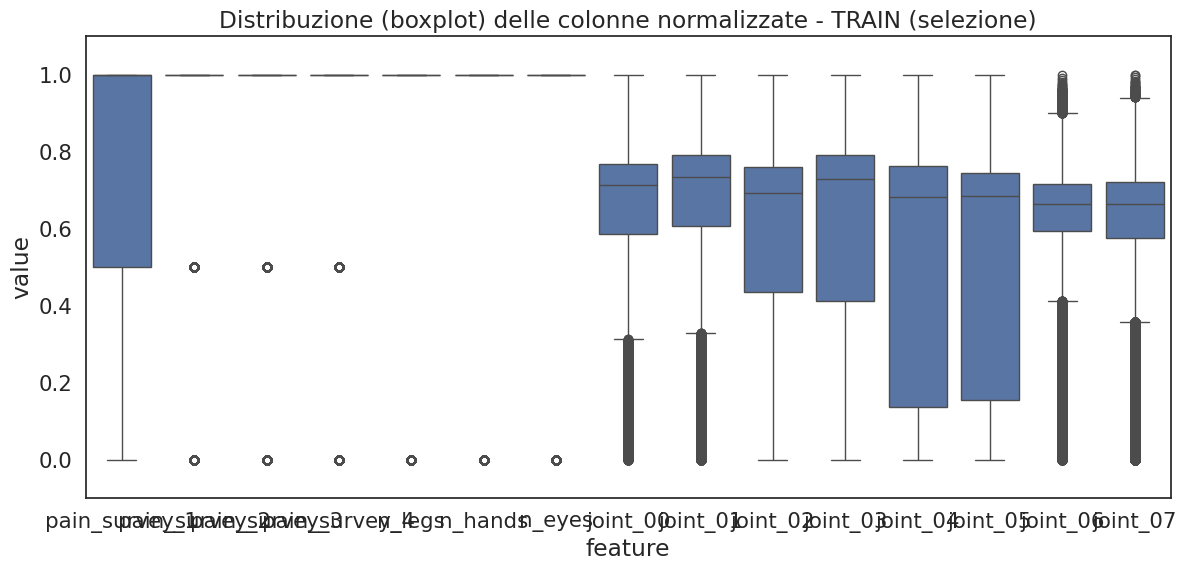


Tutte le colonne in range [0,1] (train, ignorando NaN): True
Tutte le colonne in range [0,1] (test, ignorando NaN):  False


In [12]:
# Verifica rapida che le colonne specificate siano normalizzate (valori in [0,1])
cols = scale_columns  # usa la lista già definita

# Statistiche (min, max, mean, std) su train e test
stats_train = df_train[cols].agg(['min', 'max', 'mean', 'std']).T
stats_test = df_test[cols].agg(['min', 'max', 'mean', 'std']).T

print("Statistiche di normalizzazione (train):")
print(stats_train)
print("\nStatistiche di normalizzazione (test):")
print(stats_test)

# Conta valori fuori intervallo [0,1], NaN e inf
out_of_range_train = ((df_train[cols] < 0) | (df_train[cols] > 1)).sum()
out_of_range_test = ((df_test[cols] < 0) | (df_test[cols] > 1)).sum()

nan_counts_train = df_train[cols].isna().sum()
nan_counts_test = df_test[cols].isna().sum()

inf_counts_train = np.isinf(df_train[cols]).sum()
inf_counts_test = np.isinf(df_test[cols]).sum()

print("\nValori fuori [0,1] per colonna (train):")
print(out_of_range_train[out_of_range_train > 0])
print("\nValori fuori [0,1] per colonna (test):")
print(out_of_range_test[out_of_range_test > 0])

print("\nConteggio NaN per colonna (train):")
print(nan_counts_train[nan_counts_train > 0])
print("\nConteggio NaN per colonna (test):")
print(nan_counts_test[nan_counts_test > 0])

print("\nConteggio inf per colonna (train):")
print(inf_counts_train[inf_counts_train > 0])
print("\nConteggio inf per colonna (test):")
print(inf_counts_test[inf_counts_test > 0])

# Visuale compatta: boxplot per gruppi (mostra solo alcune colonne chiave per chiarezza)
cols_to_plot = pain_survey_columns + joint_columns[:8]  # poche colonne rappresentative
melt_train = df_train[cols_to_plot].melt(var_name='feature', value_name='value')

plt.figure(figsize=(14,6))
sns.boxplot(x='feature', y='value', data=melt_train)
plt.title('Distribuzione (boxplot) delle colonne normalizzate - TRAIN (selezione)')
plt.ylim(-0.1, 1.1)  # mostra eventuali outlier fuori [0,1]
plt.show()

# Se vuoi una verifica boolean complessiva:
all_train_in_range = (out_of_range_train.sum() == 0) and (inf_counts_train.sum() == 0)
all_test_in_range = (out_of_range_test.sum() == 0) and (inf_counts_test.sum() == 0)

print(f"\nTutte le colonne in range [0,1] (train, ignorando NaN): {all_train_in_range}")
print(f"Tutte le colonne in range [0,1] (test, ignorando NaN):  {all_test_in_range}")

In [13]:
# Display the first five rows of the training DataFrame
print(df_train.shape)
df_train.head()

(97760, 40)


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,label
0,0,0,1.0,0.0,1.0,0.5,1.0,1.0,1.0,0.777507,...,2.426544e-06,1.374706e-06,0.000015,3.162812e-04,0.000004,0.014214,0.011376,0.018978,0.020291,0
1,0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.806256,...,2.757563e-07,4.026521e-07,0.000022,9.828596e-07,0.000000,0.010748,0.000000,0.009473,0.010006,0
2,0,2,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.767592,...,1.063529e-07,1.440847e-08,0.000005,6.626011e-05,0.000003,0.013097,0.006830,0.017065,0.016856,0
3,0,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.666220,...,6.981461e-06,3.065580e-07,0.000007,1.199337e-06,0.000000,0.009505,0.006274,0.020264,0.017981,0
4,0,4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.774297,...,3.076737e-06,1.723863e-08,0.000006,1.307199e-06,0.000007,0.004216,0.002132,0.023389,0.018477,0


In [14]:
# Define the window size
WINDOW_SIZE = 200

# Define the stride for overlapping windows
STRIDE = 50


In [15]:
def build_sequences(df, window=200, stride=50):
    """
    Build sequences from time-series data
    
    Args:
        df: DataFrame with the data
        window: Window size for sequences
        stride: Stride for overlapping windows
        
    Returns:
        dataset: numpy array of sequences
        labels: numpy array of labels
    """
    # Initialise lists to store sequences and their corresponding labels
    dataset = []
    labels = []

    # Iterate over unique IDs in the DataFrame
    for sample_id in df['sample_index'].unique():
        # Extract sensor data for the current ID
        drop_cols = [c for c in ['sample_index', 'time', 'label', 'labels'] if c in df.columns]
        temp = df[df['sample_index'] == sample_id].drop(columns=drop_cols).values.astype('float32')

        # Retrieve the activity label for the current ID
        label_series = df[df['sample_index'] == sample_id]['label']
        
        # Check if label column exists and has values
        if label_series.empty:
            print(f"Warning: No label found for sample_id {sample_id}")
            continue
            
        label_value = label_series.values[0]
        
        # Skip samples with NaN labels
        if pd.isna(label_value):
            print(f"Warning: NaN label for sample_id {sample_id}, skipping...")
            continue
        
        # Convert to int and validate
        try:
            label = int(label_value)
            if label < 0 or label > 2:  # Assuming 3 classes: 0, 1, 2
                print(f"Warning: Invalid label {label} for sample_id {sample_id}, skipping...")
                continue
        except (ValueError, TypeError) as e:
            print(f"Warning: Cannot convert label {label_value} to int for sample_id {sample_id}: {e}")
            continue

        # Calculate padding length to ensure full windows
        padding_len = window - len(temp) % window if len(temp) % window != 0 else 0

        # Create zero padding with correct number of features
        if padding_len > 0:
            padding = np.zeros((padding_len, temp.shape[1]), dtype='float32')
            temp = np.concatenate((temp, padding))

        # Build feature windows and associate them with labels
        idx = 0
        while idx + window <= len(temp):
            dataset.append(temp[idx:idx + window])
            labels.append(label)
            idx += stride

    # Convert lists to numpy arrays for further processing
    dataset = np.array(dataset, dtype='float32')
    labels = np.array(labels, dtype='int64')
    
    print(f"Built {len(dataset)} sequences with {len(labels)} labels")

    return dataset, labels

In [16]:
# Generate sequences and labels for the training set
X_train, y_train = build_sequences(df_train, WINDOW_SIZE, STRIDE)

# Generate sequences and labels for the validation set
X_val, y_val = build_sequences(df_val, WINDOW_SIZE, STRIDE)

# Generate sequences and labels for the test set
#X_test, y_test = build_sequences(df_test, WINDOW_SIZE, STRIDE)

# Print the shapes of the generated datasets and their labels
X_train.shape, y_train.shape, X_val.shape, y_val.shape, """ X_test.shape, y_test.shape """

Built 611 sequences with 611 labels
Built 50 sequences with 50 labels


((611, 200, 37), (611,), (50, 200, 37), (50,), ' X_test.shape, y_test.shape ')

In [17]:
# Define the input shape based on the training data
input_shape = X_train.shape[1:]

# Define the number of classes based on the categorical labels
num_classes = len(np.unique(y_train))

In [18]:
# Debug: Check for NaN and invalid values in labels
print("=== DEBUGGING LABELS ===")
print(f"\ndf_train['label'] unique values: {df_train['label'].unique()}")
print(f"df_train['label'] NaN count: {df_train['label'].isna().sum()}")
print(f"df_train['label'] dtype: {df_train['label'].dtype}")

print(f"\ndf_val['label'] unique values: {df_val['label'].unique()}")
print(f"df_val['label'] NaN count: {df_val['label'].isna().sum()}")
print(f"df_val['label'] dtype: {df_val['label'].dtype}")

# After build_sequences
print(f"\n=== AFTER BUILD_SEQUENCES ===")
print(f"y_train unique values: {np.unique(y_train)}")
print(f"y_train dtype: {y_train.dtype}")
print(f"y_train min: {y_train.min()}, max: {y_train.max()}")
print(f"y_train contains NaN: {np.isnan(y_train).any()}")

print(f"\ny_val unique values: {np.unique(y_val)}")
print(f"y_val dtype: {y_val.dtype}")
print(f"y_val min: {y_val.min()}, max: {y_val.max()}")
print(f"y_val contains NaN: {np.isnan(y_val).any()}")

# Check if any label is out of bounds [0, num_classes-1]
invalid_train = (y_train < 0) | (y_train >= num_classes)
invalid_val = (y_val < 0) | (y_val >= num_classes)
print(f"\nInvalid labels in y_train: {invalid_train.sum()}")
print(f"Invalid labels in y_val: {invalid_val.sum()}")

if invalid_train.any():
    print(f"Invalid y_train values: {y_train[invalid_train][:10]}")
if invalid_val.any():
    print(f"Invalid y_val values: {y_val[invalid_val][:10]}")

=== DEBUGGING LABELS ===

df_train['label'] unique values: [0 1 2]
df_train['label'] NaN count: 0
df_train['label'] dtype: int64

df_val['label'] unique values: [0 1 2]
df_val['label'] NaN count: 0
df_val['label'] dtype: int64

=== AFTER BUILD_SEQUENCES ===
y_train unique values: [0 1 2]
y_train dtype: int64
y_train min: 0, max: 2
y_train contains NaN: False

y_val unique values: [0 1 2]
y_val dtype: int64
y_val min: 0, max: 2
y_val contains NaN: False

Invalid labels in y_train: 0
Invalid labels in y_val: 0


In [19]:
# Convert numpy arrays to PyTorch datasets with correct data types
# PyTorch CrossEntropyLoss requires labels as Long (int64)
train_ds = TensorDataset(
    torch.from_numpy(X_train.astype(np.float32)), 
    torch.from_numpy(y_train.astype(np.int64))
)
val_ds = TensorDataset(
    torch.from_numpy(X_val.astype(np.float32)), 
    torch.from_numpy(y_val.astype(np.int64))
)

# Verify data types
print(f"Train dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(val_ds)}")
print(f"X_train dtype: {train_ds[0][0].dtype}")
print(f"y_train dtype: {train_ds[0][1].dtype}")


Train dataset size: 611
Validation dataset size: 50
X_train dtype: torch.float32
y_train dtype: torch.int64


In [20]:
BATCH_SIZE = 512

In [21]:
def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [22]:
# Create data loaders with different settings for each phase
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
#test_loader  = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [23]:
# Get one batch from the training data loader
for xb, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Labels batch shape:", yb.shape)
    break # Stop after getting one batch

Features batch shape: torch.Size([512, 200, 37])
Labels batch shape: torch.Size([512])


In [24]:
def recurrent_summary(model, input_size):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers.

    This function is designed for models whose direct children are
    nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

    Args:
        model (nn.Module): The model to analyze.
        input_size (tuple): Shape of the input tensor (e.g., (seq_len, features)).
    """

    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""
        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"
        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create a dummy input tensor with batch_size=1
    dummy_input = torch.randn(1, *input_size).to(device)

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            model(dummy_input)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---

    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

In [25]:
class RecurrentClassifier(nn.Module):
    """
    Generic RNN classifier (RNN, LSTM, GRU).
    Uses the last hidden state for classification.
    """
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',        # 'RNN', 'LSTM', or 'GRU'
            bidirectional=False,
            dropout_rate=0.2
            ):
        super().__init__()

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        # Map string name to PyTorch RNN class
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[rnn_type]

        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0

        # Create the recurrent layer
        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,       # Input shape: (batch, seq_len, features)
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        # Calculate input size for the final classifier
        if self.bidirectional:
            classifier_input_size = hidden_size * 2 # Concat fwd + bwd
        else:
            classifier_input_size = hidden_size

        # Final classification layer
        self.classifier = nn.Linear(classifier_input_size, num_classes)

    def forward(self, x):
        """
        x shape: (batch_size, seq_length, input_size)
        """

        # rnn_out shape: (batch_size, seq_len, hidden_size * num_directions)
        rnn_out, hidden = self.rnn(x)

        # LSTM returns (h_n, c_n), we only need h_n
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]

        # hidden shape: (num_layers * num_directions, batch_size, hidden_size)

        if self.bidirectional:
            # Reshape to (num_layers, 2, batch_size, hidden_size)
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)

            # Concat last fwd (hidden[-1, 0, ...]) and bwd (hidden[-1, 1, ...])
            # Final shape: (batch_size, hidden_size * 2)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            # Take the last layer's hidden state
            # Final shape: (batch_size, hidden_size)
            hidden_to_classify = hidden[-1]

        # Get logits
        logits = self.classifier(hidden_to_classify)
        return logits


# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
    input_size=input_shape[-1], # Pass the number of features
    hidden_size=128,
    num_layers=2,
    num_classes=num_classes,
    dropout_rate=0.,
    rnn_type='RNN'
    ).to(device)
recurrent_summary(rnn_model, input_size=input_shape)

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (RNN)                 [[-1, 200, 128], [2, -1, 128]] 54,400         
classifier (Linear)       [-1, 3]                      387            
Total params: 54,787
Trainable params: 54,787
Non-trainable params: 0
-------------------------------------------------------------------------------


In [26]:
# Training configuration
LEARNING_RATE = 1e-3
EPOCHS = 15
PATIENCE = 50

# Architecture
HIDDEN_LAYERS = 2        # Hidden layers
HIDDEN_SIZE = 128        # Neurons per layer

# Regularisation
DROPOUT_RATE = 0.2         # Dropout probability
L1_LAMBDA = 0            # L1 penalty
L2_LAMBDA = 0            # L2 penalty

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()

In [27]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [28]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [29]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [30]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [31]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

In [32]:
# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
    input_size=input_shape[-1], # Pass the number of features
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    bidirectional=False,
    rnn_type='RNN'
    ).to(device)
recurrent_summary(rnn_model, input_size=input_shape)

# Set up TensorBoard logging and save model architecture
experiment_name = "rnn"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
x = torch.randn(1, input_shape[0], input_shape[1]).to(device)
writer.add_graph(rnn_model, x)

# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (RNN)                 [[-1, 200, 128], [2, -1, 128]] 54,400         
classifier (Linear)       [-1, 3]                      387            
Total params: 54,787
Trainable params: 54,787
Non-trainable params: 0
-------------------------------------------------------------------------------


In [33]:
%%time
# Train model and track training history
rnn_model, training_history = fit(
    model=rnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=1,
    experiment_name="rnn",
    patience=PATIENCE
    )

# Update best model if current performance is superior
if training_history['val_f1'][-1] > best_performance:
    best_model = rnn_model
    best_performance = training_history['val_f1'][-1]

Training 15 epochs...
Epoch   1/15 | Train: Loss=1.0114, F1 Score=0.6756 | Val: Loss=0.8625, F1 Score=0.6564
Epoch   2/15 | Train: Loss=0.8305, F1 Score=0.6756 | Val: Loss=0.7339, F1 Score=0.6564
Epoch   3/15 | Train: Loss=0.7053, F1 Score=0.6756 | Val: Loss=0.7743, F1 Score=0.6564
Epoch   4/15 | Train: Loss=0.7344, F1 Score=0.6756 | Val: Loss=0.7460, F1 Score=0.6564
Epoch   5/15 | Train: Loss=0.7170, F1 Score=0.6756 | Val: Loss=0.6976, F1 Score=0.6564
Epoch   6/15 | Train: Loss=0.6864, F1 Score=0.6756 | Val: Loss=0.6935, F1 Score=0.6564
Epoch   7/15 | Train: Loss=0.6971, F1 Score=0.6756 | Val: Loss=0.6988, F1 Score=0.6564
Epoch   8/15 | Train: Loss=0.7031, F1 Score=0.6756 | Val: Loss=0.6922, F1 Score=0.6564
Epoch   9/15 | Train: Loss=0.6932, F1 Score=0.6756 | Val: Loss=0.6888, F1 Score=0.6564
Epoch  10/15 | Train: Loss=0.6879, F1 Score=0.6756 | Val: Loss=0.6926, F1 Score=0.6564
Epoch  11/15 | Train: Loss=0.6879, F1 Score=0.6756 | Val: Loss=0.6964, F1 Score=0.6564
Epoch  12/15 | Train:

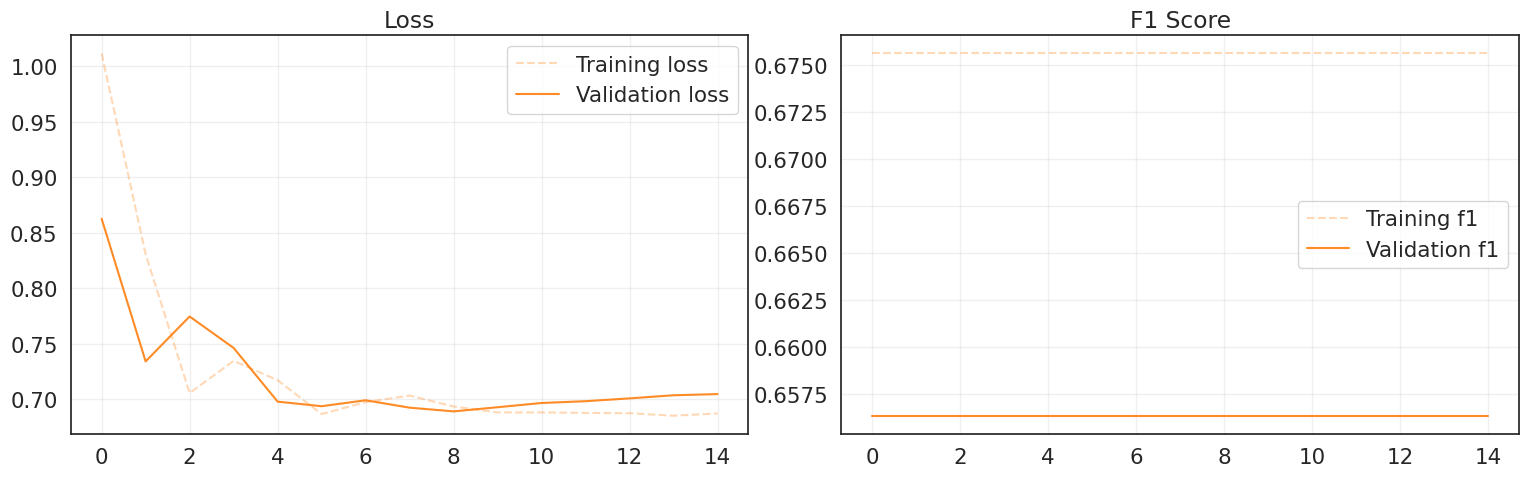

In [34]:
# @title Plot Hitory
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

Accuracy over the validation set: 0.7600
Precision over the validation set: 0.5776
Recall over the validation set: 0.7600
F1 score over the validation set: 0.6564


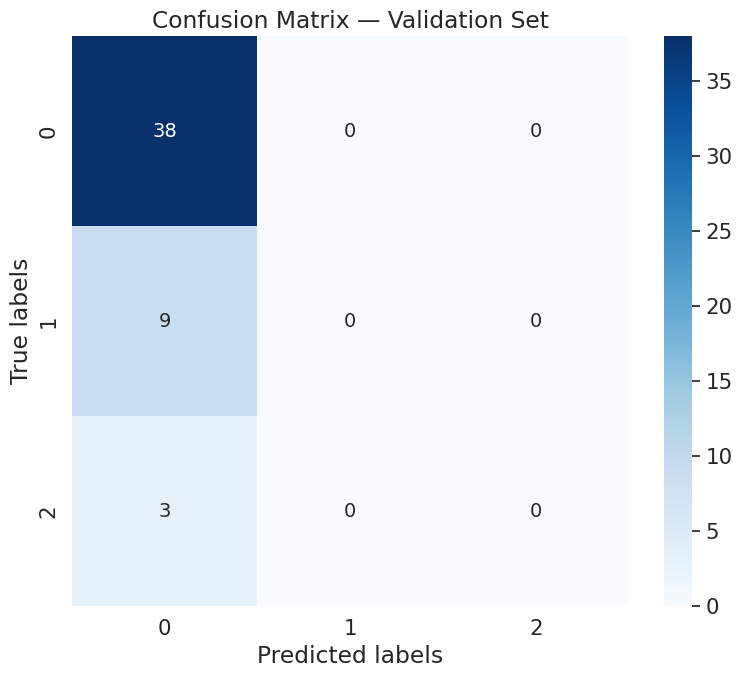

In [35]:
# @title Plot Confusion Matrix
# Collect predictions and ground truth labels
val_preds, val_targets = [], []
with torch.no_grad():  # Disable gradient computation for inference
    for xb, yb in val_loader:
        xb = xb.to(device)

        # Forward pass: get model predictions
        logits = rnn_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        val_preds.append(preds)
        val_targets.append(yb.numpy())

# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted')
val_rec = recall_score(val_targets, val_preds, average='weighted')
val_f1 = f1_score(val_targets, val_preds, average='weighted')
print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(val_targets, val_preds)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

In [36]:
# filepath: /home/federico/Desktop/ANN/ANN.ipynb
# %%time
# --- 1. Prepare test data without labels ---
print("Preparing test data for prediction...")

# Reverse mapping from integers to pain level names
label_reverse_mapping = {
    0: 'no_pain',
    1: 'low_pain',
    2: 'high_pain'
}

# Store original test data before preprocessing (for final CSV)
df_test_original = X_test.copy()

# --- 2. Get normalization parameters from training data ---
# These should be the same columns used during training normalization
pain_survey_columns = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 'n_legs', 'n_hands', 'n_eyes']
joint_columns = [f'joint_{i:02d}' for i in range(30)]  # joint_00 through joint_29
scale_columns = pain_survey_columns + joint_columns

# Get normalization parameters from training data (df_train)
train_max = df_train[scale_columns].max()
train_min = df_train[scale_columns].min()

# --- 3. Apply preprocessing to test data ---
# Create a copy to avoid modifying original
df_test_processed = X_test.copy()

# Apply same normalization as training
for column in scale_columns:
    df_test_processed[column] = (df_test_processed[column] - train_min[column]) / (train_max[column] - train_min[column] + 1e-8)

# --- 4. Build test sequences ---
# Temporarily create dummy labels for build_sequences function
df_test_processed['label'] = 0  # Dummy label (required by build_sequences)

# Build sequences using the same window and stride as training
X_test_sequences, _ = build_sequences(
    df_test_processed,
    window=WINDOW_SIZE,
    stride=STRIDE
)

print(f"Test sequences shape: {X_test_sequences.shape}")
print(f"Number of test sequences: {len(X_test_sequences)}")

# --- 5. Load the trained model ---
# Use the best model trained earlier (rnn_model)
# If you want to load from file:
model = RecurrentClassifier(
    input_size=X_test_sequences.shape[2],  # num_features (37)
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,  # 3 classes
    dropout_rate=DROPOUT_RATE,
    bidirectional=False,
    rnn_type='RNN'
).to(device)

# Load the saved model weights
model_path = "models/rnn_model.pt"

try:
    model.load_state_dict(torch.load(model_path, map_location=device))
    print(f"Model loaded from {model_path}")
except FileNotFoundError:
    print(f"WARNING: Model file not found at {model_path}")
    print("Using the model from memory (rnn_model)")
    model = rnn_model  # Use the model trained in the notebook

model.eval()

# --- 6. Create test DataLoader ---
test_ds = TensorDataset(torch.from_numpy(X_test_sequences.astype(np.float32)))
test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2 if not LOCAL else 0  # No multiprocessing on Mac
)

# --- 7. Make predictions ---
print("Making predictions on test set...")
all_predictions = []

with torch.no_grad():
    for (xb,) in test_loader:  # Note: unpacking single element tuple
        xb = xb.to(device)
        logits = model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_predictions.append(preds)

all_predictions = np.concatenate(all_predictions)
print(f"Total window predictions: {len(all_predictions)}")

# --- 8. Map predictions back to original test samples ---
# Each sample generates multiple windows, we need to aggregate them
# Strategy: Use majority voting for all windows of each sample

# Create a list to store final predictions for each sample
sample_predictions = []
pred_idx = 0

for sample_id in df_test_processed['sample_index'].unique():
    # Get data for this sample
    sample_data = df_test_processed[df_test_processed['sample_index'] == sample_id]
    n_timestamps = len(sample_data)
    
    # Calculate number of windows for this sample (same logic as build_sequences)
    padding_len = WINDOW_SIZE - n_timestamps % WINDOW_SIZE if n_timestamps % WINDOW_SIZE != 0 else 0
    total_len = n_timestamps + padding_len
    n_windows = (total_len - WINDOW_SIZE) // STRIDE + 1
    
    # Get predictions for all windows of this sample
    if pred_idx + n_windows <= len(all_predictions):
        sample_window_predictions = all_predictions[pred_idx:pred_idx + n_windows]
        
        # Use majority voting across all windows
        if len(sample_window_predictions) > 0:
            final_prediction = np.bincount(sample_window_predictions).argmax()
        else:
            final_prediction = 0  # Fallback
    else:
        print(f"Warning: Not enough predictions for sample {sample_id}")
        final_prediction = 0
    
    sample_predictions.append({
        'sample_index': sample_id,
        'predicted_label_id': final_prediction,
        'predicted_label': label_reverse_mapping[final_prediction]
    })
    
    pred_idx += n_windows

# --- 9. Create output DataFrame ---
predictions_df = pd.DataFrame(sample_predictions)

# Merge with original test data to keep sample_index
output_df = df_test_original[['sample_index']].drop_duplicates().merge(
    predictions_df,
    on='sample_index',
    how='left'
)

# --- 10. Save predictions to CSV ---
output_filename = 'pirate_pain_test_predictions.csv'
output_df[['sample_index', 'predicted_label']].to_csv(output_filename, index=False)

print(f"\nPredictions saved to {output_filename}")
print(f"Total samples predicted: {len(output_df)}")
print("\nPrediction distribution:")
print(output_df['predicted_label'].value_counts())

# Display first few predictions
print("\nFirst 10 predictions:")
print(output_df.head(10))

# Display summary statistics
print("\n=== Prediction Summary ===")
for pain_level in ['no_pain', 'low_pain', 'high_pain']:
    count = (output_df['predicted_label'] == pain_level).sum()
    percentage = (count / len(output_df)) * 100
    print(f"{pain_level}: {count} samples ({percentage:.1f}%)")

Preparing test data for prediction...
Built 1324 sequences with 1324 labels
Test sequences shape: (1324, 200, 37)
Number of test sequences: 1324
Model loaded from models/rnn_model.pt
Making predictions on test set...
Total window predictions: 1324

Predictions saved to pirate_pain_test_predictions.csv
Total samples predicted: 1324

Prediction distribution:
predicted_label
no_pain    1324
Name: count, dtype: int64

First 10 predictions:
   sample_index  predicted_label_id predicted_label
0             0                   0         no_pain
1             1                   0         no_pain
2             2                   0         no_pain
3             3                   0         no_pain
4             4                   0         no_pain
5             5                   0         no_pain
6             6                   0         no_pain
7             7                   0         no_pain
8             8                   0         no_pain
9             9                   0     